Using device: cpu
PhoBERT features cached.


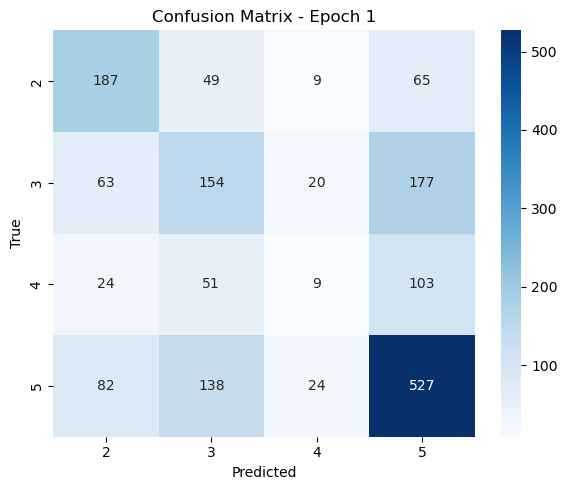

Epoch 1:
  Train Loss: 1.3865 | Train Acc: 0.3478 | Train F1: 0.2947
  Test  Loss: 1.2009 | Test  Acc: 0.5214 | Test  F1: 0.4144


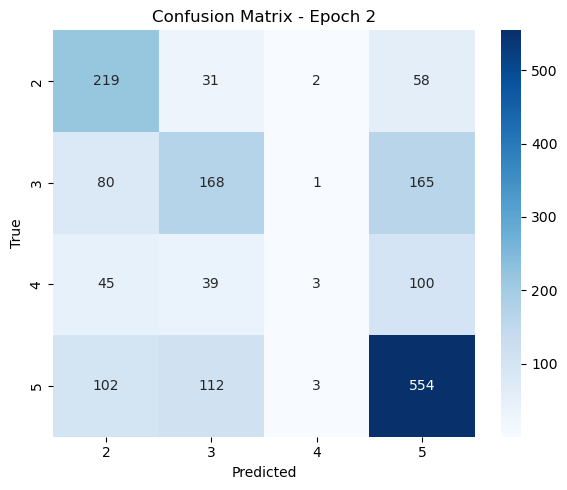

Epoch 2:
  Train Loss: 1.2325 | Train Acc: 0.4500 | Train F1: 0.3755
  Test  Loss: 1.1099 | Test  Acc: 0.5612 | Test  F1: 0.4305


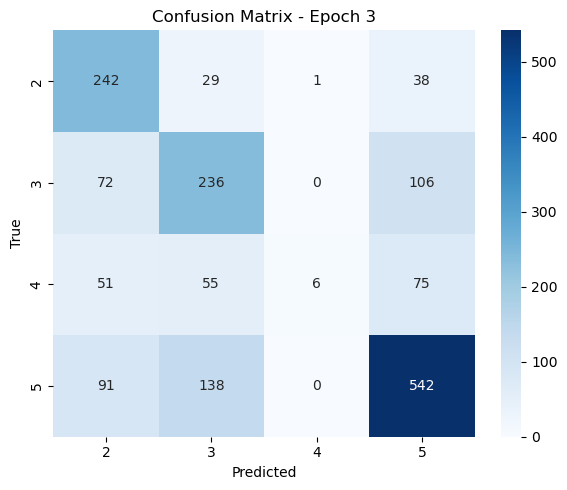

Epoch 3:
  Train Loss: 1.1348 | Train Acc: 0.5242 | Train F1: 0.4292
  Test  Loss: 1.0310 | Test  Acc: 0.6100 | Test  F1: 0.4856


KeyboardInterrupt: 

In [1]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from transformers import AutoModel, AutoTokenizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Định nghĩa đường dẫn
image_folder = 'processed_images'
mapping_file = 'processed_image_mapping.json'
data_file = 'images.json'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Dùng GPU nếu có, nếu không thì CPU
print(f'Using device: {device}')

# Load file ánh xạ và dữ liệu
with open(mapping_file, 'r') as f:
    image_mapping = json.load(f)

with open(data_file, 'r') as f:
    data = json.load(f)

# Load PhoBERT
phobert = AutoModel.from_pretrained('vinai/phobert-base').to(device)
tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')
# Đóng băng toàn bộ tham số PhoBERT để tiết kiệm tài nguyên
for param in phobert.parameters():
    param.requires_grad = False
phobert.eval()

# Cache đặc trưng PhoBERT trong RAM (32GB đủ để lưu)
name_features_cache = {}
for item in data:
    product_name = item['product_name']
    if product_name not in name_features_cache:
        inputs = tokenizer(product_name, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
        with torch.inference_mode():
            outputs = phobert(**inputs)
            name_feature = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            name_features_cache[product_name] = name_feature
print('PhoBERT features cached.')

# Load ResNet50
resnet = models.resnet50(pretrained=True).to(device)
# Chỉ fine-tune layer4 để giảm số tham số huấn luyện
for name, param in resnet.named_parameters():
    if 'layer4' not in name:
        param.requires_grad = False
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Loại bỏ lớp fully connected
resnet.train()  # Bật chế độ huấn luyện cho layer4

# Transform cho ảnh với augmentation nhẹ để giảm overfitting
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Lật ngang ngẫu nhiên
    transforms.RandomRotation(5),       # Xoay nhẹ 5 độ
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Mã hóa product_category (0-4)
categories = [item['product_category'] for item in data]
encoder = OneHotEncoder(sparse_output=False)
category_encoded = encoder.fit_transform(np.array(categories).reshape(-1, 1))

# Dataset tùy chỉnh
class HelpfulnessDataset(Dataset):
    def __init__(self, data, image_mapping, image_folder, transform, encoder, name_features_cache):
        self.data = data
        self.image_mapping = image_mapping
        self.image_folder = image_folder
        self.transform = transform
        self.encoder = encoder
        self.name_features_cache = name_features_cache
        self.image_paths = []
        self.labels = []
        self.product_names = []
        self.categories = []

        # Lọc dữ liệu hợp lệ
        for item in data:
            id_str = str(item['id'])
            if id_str in image_mapping and isinstance(item.get('Image_helpfulness'), list) and len(item['Image_helpfulness']) > 0:
                if len(image_mapping[id_str]) > 0:
                    raw_label = item['Image_helpfulness'][0]
                    if 2 <= raw_label <= 5:
                        label = raw_label - 2  # Chuyển 2-5 thành 0-3
                        for img in image_mapping[id_str]:
                            self.image_paths.append(os.path.join(image_folder, img['image_file']))
                            self.labels.append(label)
                            self.product_names.append(item['product_name'])
                            self.categories.append(item['product_category'])
                    else:
                        print(f"Warning: Skipping sample {id_str} due to invalid helpfulness label: {raw_label}")
                else:
                    print(f"Warning: Skipping sample {id_str} because no images were successfully processed.")
            else:
                print(f"Warning: Skipping sample {id_str} due to missing image mapping or invalid helpfulness label.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        product_name = self.product_names[idx]
        category = self.categories[idx]

        # Load và biến đổi ảnh
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        # Lấy đặc trưng từ cache
        name_feature = self.name_features_cache[product_name]
        category_encoded = self.encoder.transform([[category]])[0]

        return img, name_feature, category_encoded, label

# Tạo dataset và dataloader với batch_size=16 để tận dụng 32GB RAM
dataset = HelpfulnessDataset(data, image_mapping, image_folder, transform, encoder, name_features_cache)
train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)

# Định nghĩa mô hình với batch normalization và tăng dropout
class HelpfulnessModel(nn.Module):
    def __init__(self, name_feature_dim=768, category_dim=5, image_feature_dim=2048):
        super(HelpfulnessModel, self).__init__()
        self.fc1 = nn.Linear(name_feature_dim + category_dim + image_feature_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Thêm batch norm để ổn định
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.6)  # Tăng dropout để giảm overfitting
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)  # Thêm batch norm
        self.fc3 = nn.Linear(128, 4)  # 4 lớp (image_helpfulness 2-5)
        
    def forward(self, image_features, name_features, category_features):
        combined = torch.cat((image_features, name_features, category_features), dim=1)
        x = self.fc1(combined)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Khởi tạo mô hình
model = HelpfulnessModel().to(device)
criterion = nn.CrossEntropyLoss()
# Tối ưu với weight_decay cao hơn và learning rate thấp hơn
optimizer = optim.Adam(
    list(model.parameters()) + [p for p in resnet.parameters() if p.requires_grad],
    lr=2e-5, weight_decay=5e-4
)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

# Hàm huấn luyện với early stopping
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=25, patience=3):
    best_acc = 0.0
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        resnet.train()  # Đảm bảo layer4 ở chế độ huấn luyện
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []
        
        # Vòng lặp huấn luyện
        for images, name_features, category_features, labels in train_loader:
            images = images.to(device)
            name_features = torch.tensor(name_features, dtype=torch.float32).to(device)
            category_features = torch.tensor(category_features, dtype=torch.float32).to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)
            
            optimizer.zero_grad()
            image_features = resnet(images).squeeze().to(device)
            outputs = model(image_features, name_features, category_features)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_loss /= train_total
        train_acc = train_correct / train_total
        train_f1 = f1_score(train_labels, train_preds, average='macro')
        
        # Đánh giá
        model.eval()
        resnet.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        test_preds = []
        test_labels = []
        
        with torch.inference_mode():
            for images, name_features, category_features, labels in test_loader:
                images = images.to(device)
                name_features = torch.tensor(name_features, dtype=torch.float32).to(device)
                category_features = torch.tensor(category_features, dtype=torch.float32).to(device)
                labels = torch.tensor(labels, dtype=torch.long).to(device)
                
                image_features = resnet(images).squeeze().to(device)
                outputs = model(image_features, name_features, category_features)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())
        
        test_loss /= test_total
        test_acc = test_correct / test_total
        test_f1 = f1_score(test_labels, test_preds, average='macro')
        test_cm = confusion_matrix(test_labels, test_preds, labels=[0, 1, 2, 3])
        
        # Vẽ biểu đồ nhầm lẫn cho từng epoch
        plt.figure(figsize=(6, 5))
        sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[2, 3, 4, 5], yticklabels=[2, 3, 4, 5])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - Epoch {epoch+1}')
        plt.tight_layout()
        plt.show()
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')
        print(f'  Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc:.4f} | Test  F1: {test_f1:.4f}')
        
        # Early stopping
        if test_acc > best_acc:
            best_acc = test_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_helpfulness_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
        
        # Cập nhật scheduler
        scheduler.step(test_acc)

# Huấn luyện mô hình
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=25, patience=3)

print('Training completed. Best model saved to best_helpfulness_model.pth')